# Start


In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import hashlib

In [3]:
# Step 0: Set your name for unique dataset creation
your_name = "anubhavdubey"  # Replace with your name
# Create a hash value from the name
hash_value = hashlib.md5(your_name.replace(" ", "").lower().encode()).hexdigest()
print(f"Hash value for '{your_name}': {hash_value}")

Hash value for 'anubhavdubey': 6077ba479993e919aee93c314abaf443


In [4]:
# Step 1: Load the files
# Load phenotype-gene pairs
phenotype_gene_pairs = pd.read_csv('data/benchmark_datasets/opentargets_step2.for_llm.tsv', sep='\t')
# Load causal genes
causal_genes = pd.read_csv('data/benchmark_datasets/opentargets_step2.labels', sep='\t')
# Load embeddings
gene_embeddings = pd.read_csv('data/helper_datasets/gene_embeddings.csv')
phenotype_embeddings = pd.read_csv('data/helper_datasets/phenotype_embeddings.csv')


In [8]:
print(phenotype_gene_pairs['description'][1])

Bilirubin levels


In [5]:
hash_seed = int(hash_value, 16) % (2**32)  # Ensure the seed is in range
np.random.seed(hash_seed)  # Use hash as seed for reproducibility

# Get unique phenotype-gene pairs
unique_pairs = phenotype_gene_pairs[['description', 'symbol_gene_string']].drop_duplicates()

# Check the number of unique phenotypes
num_unique_phenotypes = len(unique_pairs)
sample_size = min(num_unique_phenotypes, 500)  # Use the minimum of available phenotypes or 500

# Sample phenotypes without replacement
sampled_unique_pairs = unique_pairs.sample(n=sample_size, random_state=hash_seed)

# Print the sampled phenotypes and symbols
print("Sampled unique phenotypes and symbols:")
print(sampled_unique_pairs)

Sampled unique phenotypes and symbols:
                                           description  \
113  Blood metabolite levels (X-12441--12-hydroxyei...   
104  Urinary metabolites (H-NMR features) (1.7325, ...   
466                              Myocardial infarction   
169  Blood metabolite levels (5-oxoproline) (Pyrogl...   
124  Blood metabolite ratios (aspartylphenylalanine...   
..                                                 ...   
126                  Blood metabolite levels (betaine)   
524        Type 2 diabetes (type II diabetes mellitus)   
379                                 Ulcerative colitis   
661  Type 2 diabetes (adjusted for BMI) (type II di...   
211                              Citrate (Citric acid)   

                                    symbol_gene_string  
113  {ACADVL},{ACAP1},{ALOX12},{ASGR1},{ASGR2},{BCL...  
104  {ANKRD27},{CEBPA},{CEP89},{DPY19L3},{FAAP24},{...  
466  {DNAH8},{GLO1},{GLP1R},{KCNK16},{KCNK17},{KCNK...  
169  {ADCK5},{ARHGAP39},{BOP1},{C8or

In [6]:
import pandas as pd

mapping_data = []

# Iterate over the unique pairs of phenotype and associated genes
for index, row in sampled_unique_pairs.iterrows():
    phenotype = row['description']
    symbol_string = row['symbol_gene_string']  # Get the symbol gene string
    
    # Split the symbols in case they are in a string format like "{GENE1},{GENE2}"
    symbol_list = [symbol.strip('{} ') for symbol in symbol_string.split(',')]  # Clean symbol list
    
    # Get the corresponding associated genes for the phenotype from phenotype_gene_pairs
    genes_str = phenotype_gene_pairs[phenotype_gene_pairs['description'] == phenotype]['symbol_gene_string'].tolist()
    
    # Flatten the list of associated genes (assuming the list has multiple entries)
    genes = []
    if genes_str:
        genes = [gene.strip('{} ') for gene in ','.join(genes_str).split(',')]
    
    # Initialize a list to hold the causal genes found for the current phenotype
    causal_genes_found = []
    
    # Check each symbol in the symbol_list against the causal genes
    for symbol in symbol_list:
        # Get the causal gene from the causal genes dataset by matching symbols
        causal_genes_for_phenotype = causal_genes[causal_genes['symbol'] == symbol]
        
        if not causal_genes_for_phenotype.empty:
            # Get the causal gene found
            causal_gene = causal_genes_for_phenotype['symbol'].values[0]
            
            # Add causal gene to the found list
            causal_genes_found.append(causal_gene)
            
            # If causal gene is found in associated genes, remove it from the associated genes list
            if causal_gene in genes:
                genes.remove(causal_gene)
    
    # If we found any causal genes, append the results along with the modified associated genes
    if causal_genes_found:
        # Store the phenotype, the first causal gene, and the modified associated genes list
        mapping_data.append((phenotype, causal_genes_found[0], genes))

# Convert mapping data to DataFrame for analysis
mapping_df = pd.DataFrame(mapping_data, columns=['phenotype', 'causal_gene', 'remaining_associated_genes'])

# Check if mapping_df is empty
if mapping_df.empty:
    print("No valid mappings found. Please check the input datasets.")
else:
    print(f"Found {len(mapping_df)} valid mappings.")
    print(mapping_df)


Found 493 valid mappings.
                                             phenotype causal_gene  \
0    Blood metabolite levels (X-12441--12-hydroxyei...      ALOX12   
1    Urinary metabolites (H-NMR features) (1.7325, ...      SLC7A9   
2                                Myocardial infarction       GLP1R   
3    Blood metabolite levels (5-oxoproline) (Pyrogl...         GPT   
4    Blood metabolite ratios (aspartylphenylalanine...         ACE   
..                                                 ...         ...   
488                  Blood metabolite levels (betaine)     SLC6A12   
489        Type 2 diabetes (type II diabetes mellitus)        IGF2   
490                                 Ulcerative colitis      GABRA2   
491  Type 2 diabetes (adjusted for BMI) (type II di...        GRM8   
492                              Citrate (Citric acid)       PRODH   

                            remaining_associated_genes  
0    [ACADVL, ACAP1, ASGR1, ASGR2, BCL6B, C17orf100...  
1    [ANKRD27, CEBP

In [35]:
print(mapping_df['phenotype'].head())

0    Blood metabolite levels (X-12441--12-hydroxyei...
1    Urinary metabolites (H-NMR features) (1.7325, ...
2                                Myocardial infarction
3    Blood metabolite levels (5-oxoproline) (Pyrogl...
4    Blood metabolite ratios (aspartylphenylalanine...
Name: phenotype, dtype: object


In [33]:
print(mapping_df['causal_gene'].head())

0    ALOX12
1    SLC7A9
2     GLP1R
3       GPT
4       ACE
Name: causal_gene, dtype: object


In [34]:
print(mapping_df['remaining_associated_genes'].head())

0    [ACADVL, ACAP1, ASGR1, ASGR2, BCL6B, C17orf100...
1    [ANKRD27, CEBPA, CEP89, DPY19L3, FAAP24, GPATC...
2    [ASIC5, CTSO, GUCY1A1, GUCY1B1, MAP9, TDO2, DN...
3    [ADCK5, ARHGAP39, BOP1, C8orf82, CCDC166, CPSF...
4    [CCDC47, CD79B, CSH1, CSH2, CSHL1, CYB561, DCA...
Name: remaining_associated_genes, dtype: object


In [40]:
print("Unique gene symbols in gene_embeddings:", gene_embeddings['0'].unique())


Unique gene symbols in gene_embeddings: ['ATMIN' 'BCO1' 'C16orf46' ... 'PAFAH1B1' 'TBX4' 'IGHE']


In [7]:
# Ensure embeddings are converted from string representation to numpy array
def convert_to_float_array(embedding_string):
    # Convert the string representation of the list into a float array
    return np.array([float(num) for num in embedding_string.strip('[]').split(',')])

# Initialize lists to store the embeddings
causal_gene_embeddings = []
phenotype_embeddings_list = []
associated_gene_embeddings_data = []

for _, row in mapping_df.iterrows():
    phenotype = row['phenotype']
    causal_gene = row['causal_gene']
    associated_string = row['remaining_associated_genes']  # Expecting string format like "{GENE1},{GENE2}"
    
    # Initialize list to store embeddings of the associated genes for this row
    associated_gene_embeddings = []
    
    # Ensure associated_string is a string
    # if isinstance(associated_string, str):
    #     # Split the symbols, assuming they are in a format like "{GENE1},{GENE2}"
    #     associated_genes = [associated.strip('{} ') for associated in associated_string.split(',')]
        
    for gene in associated_string:
            # Strip braces and any whitespace from the gene symbol
            gene_symbol = gene.strip('{} ')
            
            # Find the corresponding embedding for the gene
            gene_embedding = gene_embeddings[gene_embeddings['0'] == gene_symbol]['embedding'].values
            
            if gene_embedding.size > 0:
                # Convert string embedding to float array
                associated_gene_embeddings.append(convert_to_float_array(gene_embedding[0]))
    
    # Append the list of associated gene embeddings for this row
    associated_gene_embeddings_data.append(associated_gene_embeddings)
    
    # Find the corresponding embedding for the causal gene
    causal_gene_embedding = gene_embeddings[gene_embeddings['0'] == causal_gene]['embedding'].values
    if causal_gene_embedding.size > 0:
        causal_gene_embeddings.append(convert_to_float_array(causal_gene_embedding[0]))
    
    # Find the corresponding embedding for the phenotype
    phenotype_embedding = phenotype_embeddings[phenotype_embeddings['0'] == phenotype]['embedding'].values
    if phenotype_embedding.size > 0:
        phenotype_embeddings_list.append(convert_to_float_array(phenotype_embedding[0]))

# Convert lists to numpy arrays for causal and phenotype embeddings
causal_gene_embeddings = np.array(causal_gene_embeddings)
phenotype_embeddings_list = np.array(phenotype_embeddings_list)

# Print the shapes of the resulting arrays for verification
print("Causal Gene Embeddings shape:", causal_gene_embeddings.shape)
print("Phenotype Embeddings shape:", phenotype_embeddings_list.shape)

# The associated_gene_embeddings_data is a list of lists, no need to convert to an array
# since each row may have a different number of associated genes
print("Associated Gene Embeddings data length (rows):", len(associated_gene_embeddings_data))


Causal Gene Embeddings shape: (493, 3072)
Phenotype Embeddings shape: (467, 3072)
Associated Gene Embeddings data length (rows): 493


In [10]:
# Truncate the causal_gene_embeddings and associated_gene_embeddings_data to match the phenotype_embeddings_list length
min_length = min(len(causal_gene_embeddings), len(phenotype_embeddings_list), len(associated_gene_embeddings_data))

# Truncate each list/array to the minimum length
causal_gene_embeddings = causal_gene_embeddings[:min_length]
phenotype_embeddings_list = phenotype_embeddings_list[:min_length]
associated_gene_embeddings_data = associated_gene_embeddings_data[:min_length]

# Now create the DataFrame
df = pd.DataFrame({
    'causal_gene_embedding': list(causal_gene_embeddings),  # Convert array to list for each row
    'phenotype_embedding': list(phenotype_embeddings_list),  # Convert array to list for each row
    'associated_gene_embeddings': associated_gene_embeddings_data  # List of lists directly
})

# Print the DataFrame to verify
print(df.head())


                               causal_gene_embedding  \
0  [-0.028298845514655113, 0.024347418919205666, ...   
1  [0.010303813964128494, 0.06047238036990166, -0...   
2  [-0.0038186870515346527, 0.023183757439255714,...   
3  [-0.005440321750938892, 0.019649161025881767, ...   
4  [-0.0027003700379282236, 0.03175245225429535, ...   

                                 phenotype_embedding  \
0  [-0.0331123061478138, -0.021348722279071808, -...   
1  [0.00324897444806993, 0.008687998168170452, -0...   
2  [-0.0178254134953022, 0.021464768797159195, -0...   
3  [-0.04565058648586273, -0.011102771386504173, ...   
4  [-0.021806569769978523, 0.02328665368258953, -...   

                          associated_gene_embeddings  
0  [[-0.017535071820020676, 0.043653566390275955,...  
1  [[0.006839119829237461, 0.015947440639138222, ...  
2  [[-0.01670944131910801, 0.04606017470359802, -...  
3  [[0.02858160436153412, 0.03450208157300949, -0...  
4  [[-0.01645924150943756, -0.016924476251006126,..

In [8]:
print(associated_gene_embeddings)

[array([-0.02292394,  0.02934776, -0.00014317, ..., -0.00724116,
       -0.0247502 ,  0.00117334]), array([-0.02829885,  0.02434742, -0.0036882 , ..., -0.00106402,
       -0.01007969, -0.02711578]), array([ 0.00285898,  0.06500158, -0.00879353, ..., -0.02542141,
       -0.01663407, -0.01100274]), array([ 0.00254584,  0.05535829, -0.00552417, ..., -0.0196306 ,
       -0.02273469,  0.00092862]), array([ 0.04093882,  0.02671082, -0.01034378, ..., -0.00373273,
        0.00142856, -0.01176779]), array([-0.00502435,  0.01117195, -0.01388255, ..., -0.01119213,
       -0.02246497, -0.01997634]), array([ 0.00226961,  0.00453278, -0.01376575, ..., -0.01630256,
       -0.02686188, -0.02438946]), array([-0.03626853,  0.01044002, -0.0068156 , ...,  0.00174814,
        0.00206695,  0.00204255]), array([ 0.02000091,  0.03101094, -0.0113148 , ...,  0.00093734,
       -0.00796862, -0.01645789]), array([-0.01393515,  0.02279203, -0.01299651, ..., -0.00751511,
        0.00400726, -0.00254214]), array([ 0

In [11]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Function to calculate cosine similarity between two embeddings
def cosine_similarity_percentage(vec1, vec2):
    # Calculate cosine similarity (will return a value between -1 and 1)
    cos_sim = cosine_similarity([vec1], [vec2])[0][0]
    # Convert to percentage (0-100)
    return (cos_sim + 1) / 2 * 100  # Mapping cosine similarity (-1, 1) to percentage (0, 100)

# Initialize lists to store the results
causal_gene_similarity = []
associated_gene_similarity = []

# Iterate over each row of the DataFrame
for index, row in df.iterrows():
    causal_embedding = row['causal_gene_embedding']
    phenotype_embedding = row['phenotype_embedding']
    associated_embeddings = row['associated_gene_embeddings']  # List of vectors

    # Calculate cosine similarity between causal gene and phenotype
    if causal_embedding is not None and phenotype_embedding is not None:
        causal_sim = cosine_similarity_percentage(causal_embedding, phenotype_embedding)
    else:
        causal_sim = None

    # Calculate cosine similarity between each associated gene embedding and phenotype embedding
    associated_similarities = []
    if isinstance(associated_embeddings, list) and phenotype_embedding is not None:
        for associated_embedding in associated_embeddings:
            if associated_embedding is not None:
                associated_sim = cosine_similarity_percentage(associated_embedding, phenotype_embedding)
                associated_similarities.append(associated_sim)
            else:
                associated_similarities.append(None)

    # Store the results
    causal_gene_similarity.append(causal_sim)
    associated_gene_similarity.append(associated_similarities)

# Add the calculated similarities to the DataFrame
df['causal_gene_similarity'] = causal_gene_similarity
df['associated_gene_similarity'] = associated_gene_similarity

# Convert associated_gene_similarity (list of percentages) to a string for saving in CSV
df['associated_gene_similarity'] = df['associated_gene_similarity'].apply(lambda x: ','.join(map(str, x)))

# Save the DataFrame to a CSV file
df.to_csv('gene_similarity_results.csv', index=False)

print("Cosine similarity results saved to 'gene_similarity_results.csv'")


Cosine similarity results saved to 'gene_similarity_results.csv'


# Applying PCA

##### To visualize the relationships between the phenotype and gene embeddings, we can apply Principal Component Analysis (PCA) to reduce the dimensionality of the embeddings. PCA will allow us to reduce the high-dimensional embeddings (e.g., 3072 dimensions) into two or three dimensions, which can then be easily visualized using scatter plots.
#### Steps:
* Combine the embedding vectors: We need to combine the causal_gene_embedding, phenotype_embedding, and associated_gene_embeddings into one dataset for dimensionality reduction.
* Apply PCA: Use PCA to reduce the dimensionality of the embedding vectors to 2D or 3D for visualization.
* Visualization: Plot the reduced embeddings to visually compare the relationships between the causal gene, associated genes, and phenotype.

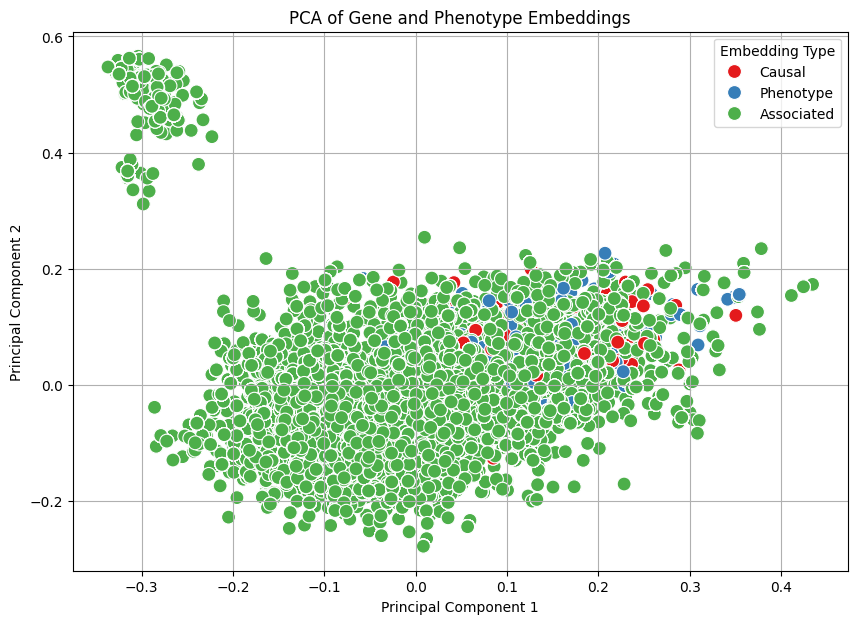

In [12]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Combine the embeddings (causal gene, phenotype, and associated genes) into one list for PCA
all_embeddings = []

# Add each embedding to the all_embeddings list
for index, row in df.iterrows():
    # Add the causal gene embedding
    if row['causal_gene_embedding'] is not None:
        all_embeddings.append(row['causal_gene_embedding'])
    
    # Add the phenotype embedding
    if row['phenotype_embedding'] is not None:
        all_embeddings.append(row['phenotype_embedding'])
    
    # Add each associated gene embedding
    for assoc_embedding in row['associated_gene_embeddings']:
        if assoc_embedding is not None:
            all_embeddings.append(assoc_embedding)

# Convert list of embeddings to a numpy array for PCA
all_embeddings_array = np.array(all_embeddings)

# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(all_embeddings_array)

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

# Label the embeddings in the DataFrame (Causal, Phenotype, Associated)
labels = []
for index, row in df.iterrows():
    labels.append('Causal')  # Causal gene label
    labels.append('Phenotype')  # Phenotype label
    labels.extend(['Associated'] * len(row['associated_gene_embeddings']))  # Associated genes label

pca_df['label'] = labels

# Plotting the results using seaborn or matplotlib
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='label', data=pca_df, palette='Set1', s=100)

plt.title("PCA of Gene and Phenotype Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Embedding Type")
plt.grid(True)
plt.show()


# Vector Analysis


##### To perform vector analysis on the gene and phenotype embeddings, we can derive new vectors that represent the relationships between the causal_gene_embeddings, phenotype_embeddings, and associated_gene_embeddings. This kind of analysis can provide insights into how closely the embeddings (which represent genes and phenotypes) relate to each other, and possibly reveal patterns in causality.

* Difference Vectors:Create vectors that represent the difference between causal_gene_embedding and phenotype_embedding, as well as between associated_gene_embeddings and phenotype_embedding. This can give us an idea of the "distance" or difference in the embedding space, which can correlate to causality.
Vector Operations:

* Magnitude (Norm): Compute the magnitude (Euclidean norm) of the difference vectors to quantify the distance.
Direction: Use cosine similarity between vectors to understand directional relationships between the genes and phenotype embeddings.
Vector Comparison:

* Compare the causal gene and associated gene embeddings with the phenotype to see how closely they align with it.

In [13]:
import numpy as np
import pandas as pd
from numpy.linalg import norm
from sklearn.metrics.pairwise import cosine_similarity

# Initialize lists to store the results of vector analysis
difference_vectors_causal = []
difference_vectors_associated = []
cosine_similarities_causal = []
cosine_similarities_associated = []
magnitudes_causal = []
magnitudes_associated = []

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    causal_embedding = np.array(row['causal_gene_embedding'])
    phenotype_embedding = np.array(row['phenotype_embedding'])
    
    # 1. Compute the difference vector between causal gene and phenotype
    diff_vector_causal = causal_embedding - phenotype_embedding
    difference_vectors_causal.append(diff_vector_causal)
    
    # Calculate the cosine similarity between the causal gene and phenotype
    cosine_sim_causal = cosine_similarity([causal_embedding], [phenotype_embedding])[0][0]
    cosine_similarities_causal.append(cosine_sim_causal)
    
    # Calculate the magnitude (norm) of the difference vector for causal gene
    magnitude_causal = norm(diff_vector_causal)
    magnitudes_causal.append(magnitude_causal)
    
    # 2. For associated gene embeddings, perform similar calculations
    assoc_gene_magnitudes = []
    assoc_gene_cosines = []
    for assoc_embedding in row['associated_gene_embeddings']:
        assoc_embedding = np.array(assoc_embedding)
        
        # Compute the difference vector between associated gene and phenotype
        diff_vector_associated = assoc_embedding - phenotype_embedding
        difference_vectors_associated.append(diff_vector_associated)
        
        # Calculate cosine similarity between associated gene and phenotype
        cosine_sim_assoc = cosine_similarity([assoc_embedding], [phenotype_embedding])[0][0]
        assoc_gene_cosines.append(cosine_sim_assoc)
        
        # Calculate the magnitude of the difference vector for associated gene
        magnitude_associated = norm(diff_vector_associated)
        assoc_gene_magnitudes.append(magnitude_associated)
    
    # Append the list of cosine similarities and magnitudes for associated genes
    cosine_similarities_associated.append(assoc_gene_cosines)
    magnitudes_associated.append(assoc_gene_magnitudes)

# Create a new DataFrame to store the results of vector analysis
vector_analysis_df = pd.DataFrame({
    'causal_gene_embedding': df['causal_gene_embedding'],
    'phenotype_embedding': df['phenotype_embedding'],
    'associated_gene_embeddings': df['associated_gene_embeddings'],
    'cosine_similarity_causal': cosine_similarities_causal,
    'magnitude_causal': magnitudes_causal,
    'cosine_similarity_associated': cosine_similarities_associated,
    'magnitude_associated': magnitudes_associated
})

# Optionally save the results to a CSV file for further analysis
vector_analysis_df.to_csv('gene_phenotype_vector_analysis.csv', index=False)

# Display the first few rows of the DataFrame to verify results
print(vector_analysis_df.head())


                               causal_gene_embedding  \
0  [-0.028298845514655113, 0.024347418919205666, ...   
1  [0.010303813964128494, 0.06047238036990166, -0...   
2  [-0.0038186870515346527, 0.023183757439255714,...   
3  [-0.005440321750938892, 0.019649161025881767, ...   
4  [-0.0027003700379282236, 0.03175245225429535, ...   

                                 phenotype_embedding  \
0  [-0.0331123061478138, -0.021348722279071808, -...   
1  [0.00324897444806993, 0.008687998168170452, -0...   
2  [-0.0178254134953022, 0.021464768797159195, -0...   
3  [-0.04565058648586273, -0.011102771386504173, ...   
4  [-0.021806569769978523, 0.02328665368258953, -...   

                          associated_gene_embeddings  \
0  [[-0.017535071820020676, 0.043653566390275955,...   
1  [[0.006839119829237461, 0.015947440639138222, ...   
2  [[-0.01670944131910801, 0.04606017470359802, -...   
3  [[0.02858160436153412, 0.03450208157300949, -0...   
4  [[-0.01645924150943756, -0.0169244762510061

#### KMeans Clustering 



* Clustering Methods:We will use clustering algorithms like K-Means and DBSCAN to group similar embeddings. These clusters may represent groups of genes or phenotypes that share similar properties.


* Dimensionality Reduction:Before applying clustering, we will reduce the dimensionality of the embeddings using PCA (Principal Component Analysis) to facilitate clustering and visualization.
Visualization:

* After clustering, we will visualize the results using 2D plots to see how the clusters are formed.
Assess Patterns:

* Once clustering is done, we can inspect the clusters to determine if they reveal distinct groups of genes that share similar relationships with phenotypes.

c:\Users\DELL\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


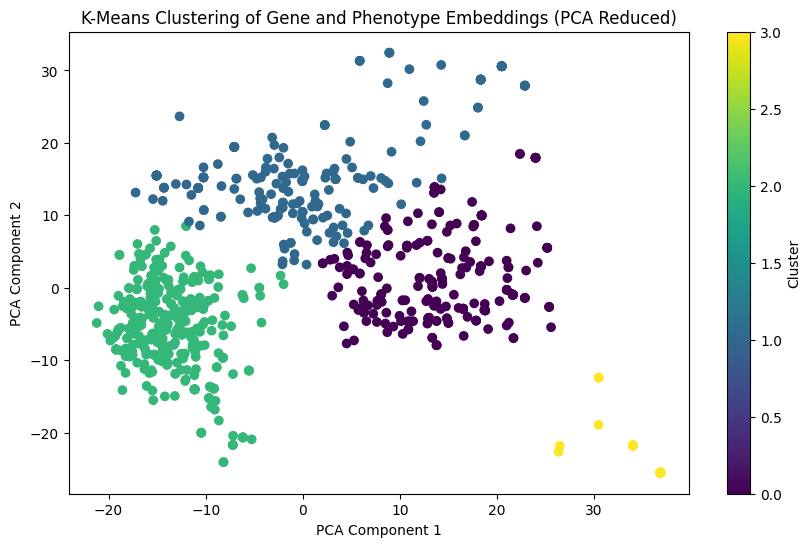

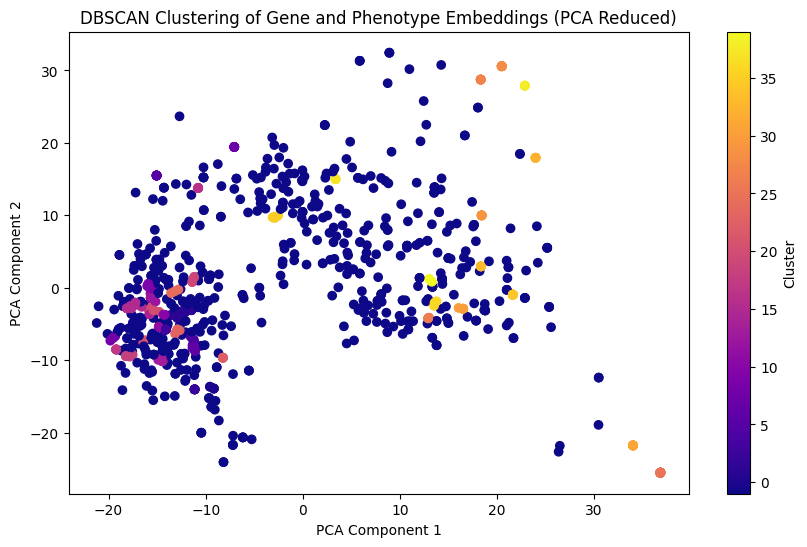

                               causal_gene_embedding  \
0  [-0.028298845514655113, 0.024347418919205666, ...   
1  [0.010303813964128494, 0.06047238036990166, -0...   
2  [-0.0038186870515346527, 0.023183757439255714,...   
3  [-0.005440321750938892, 0.019649161025881767, ...   
4  [-0.0027003700379282236, 0.03175245225429535, ...   

                                 phenotype_embedding  \
0  [-0.0331123061478138, -0.021348722279071808, -...   
1  [0.00324897444806993, 0.008687998168170452, -0...   
2  [-0.0178254134953022, 0.021464768797159195, -0...   
3  [-0.04565058648586273, -0.011102771386504173, ...   
4  [-0.021806569769978523, 0.02328665368258953, -...   

                          associated_gene_embeddings  causal_gene_similarity  \
0  [[-0.017535071820020676, 0.043653566390275955,...               79.315973   
1  [[0.006839119829237461, 0.015947440639138222, ...               71.171845   
2  [[-0.01670944131910801, 0.04606017470359802, -...               67.143493   
3  [[0

In [14]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Standardize the data before clustering
scaler = StandardScaler()

# Combine causal_gene_embeddings and phenotype_embeddings for clustering
combined_embeddings = np.concatenate([df['causal_gene_embedding'].tolist(), df['phenotype_embedding'].tolist()])
scaled_embeddings = scaler.fit_transform(combined_embeddings)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
reduced_embeddings = pca.fit_transform(scaled_embeddings)

# K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)  # Set 4 clusters as an example
kmeans_labels = kmeans.fit_predict(reduced_embeddings)

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Set appropriate parameters for DBSCAN
dbscan_labels = dbscan.fit_predict(reduced_embeddings)

# Add cluster labels to the DataFrame for analysis
df['kmeans_cluster'] = kmeans_labels[:len(df)]  # Assign KMeans clusters
df['dbscan_cluster'] = dbscan_labels[:len(df)]  # Assign DBSCAN clusters

# Visualize K-Means Clustering
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=kmeans_labels, cmap='viridis')
plt.title('K-Means Clustering of Gene and Phenotype Embeddings (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Visualize DBSCAN Clustering
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=dbscan_labels, cmap='plasma')
plt.title('DBSCAN Clustering of Gene and Phenotype Embeddings (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Save clustering results to CSV for further analysis
df.to_csv('gene_phenotype_clustering_analysis.csv', index=False)

# Display first few rows of the DataFrame with clustering results
print(df.head())


# end